Cleaning up and simplifying the dateframe to reduce memory and runtime

In [1]:
# If not already installed, do: pip install pandas fastparquet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import dask.dataframe as ddf
from dask.diagnostics import ProgressBar
from tqdm.auto import tqdm

In [2]:
URL_LOOKUP = 'https://storage.googleapis.com/dosm-public-pricecatcher/lookup_item.parquet'
URL_PREMISE = 'https://storage.googleapis.com/dosm-public-pricecatcher/lookup_premise.parquet'
url_file = 'pricecatcher/pricecatcher/price_urls.json'

In [3]:
with open(url_file, 'r') as json_file: 
    price_urls_data = json.load(json_file)

#
#for entry in price_urls_data:
#        parquet_urls = entry['parquet_files']
#        for url in parquet_urls:
#            df = ddf.read_parquet(url, blocksize = '1GB', npartitions = 20)
#            if 'date' in df.columns: df['date'] = ddf.to_datetime(df['date'])
#            df = df[(df['item_code'] != -1) | (df['premise_code'] != -1)]
#            price_dfs.append(df)

price_2022 = ddf.from_pandas(pd.DataFrame(), npartitions=12)
price_2023 = ddf.from_pandas(pd.DataFrame(), npartitions=12)

for entry in price_urls_data:
    parquet_urls = entry['parquet_files']
    for url in parquet_urls:
        year = int(url.split('_')[1].split('-')[0])
        df = ddf.read_parquet(url, blocksize = '1GB', npartitions = 12)
        if 'date' in df.columns: df['date'] = ddf.to_datetime(df['date'])
        df = df[(df['item_code'] != -1) | (df['premise_code'] != -1)]
        df['premise_code'] = df['premise_code'].astype('int32')

        if year == 2022: price_2022 = ddf.concat([price_2022, df], axis=0, ignore_index=True)
        elif year == 2023: price_2023 = ddf.concat([price_2023, df], axis=0, ignore_index=True)

premise = ddf.read_parquet(URL_PREMISE, npartitions = 8)
lookup = ddf.read_parquet(URL_LOOKUP, npartitions = 8)
premise = premise.dropna()
lookup = lookup.dropna()
if 'date' in lookup.columns: lookup['date'] = ddf.to_datetime(lookup['date'])
if 'date' in premise.columns: premise['date'] = ddf.to_datetime(premise['date'])

premise['premise_code'] = premise['premise_code'].astype('int32')
premise = premise.drop(columns = ['premise_type', 'address', 'premise', 'district'])
price_2022 = premise.merge(price_2022, on='premise_code', how='left', indicator=False)
price_2023 = premise.merge(price_2023, on='premise_code', how='left', indicator=False)

del df
del json_file
del parquet_urls
del url
del URL_PREMISE
del URL_LOOKUP
del url_file
del price_urls_data
del premise


CREATE A DICT SO USER CAN ACCESS USING ITEM AND PREMISE CODE INSTEAD OF NAME

In [4]:
#print(lookup.head())

In [5]:
lookup_dict = {}

for index, row in tqdm(lookup.iterrows(), total=len(lookup)):
    key_tuple = tuple([row['item'], row['item_category']])
    lookup_dict[key_tuple] = row['item_code']

del key_tuple
del row
del index
del lookup


  0%|          | 0/756 [00:00<?, ?it/s]

Filter the DDF based on user input

In [6]:
from dask import delayed, compute
from distributed import Client, LocalCluster
from fuzzywuzzy import fuzz
import ipywidgets as widgets
from IPython.display import display, clear_output,HTML
import concurrent.futures
import easygui

In [7]:
item_name = ''
item_state = ''


def match(input, choices, threshold=80):
    match_score = [(choice, fuzz.partial_ratio(input, choice.lower())) for choice in choices if isinstance(choice, str)]
    matched_item = max(match_score, key=lambda x: x[1], default=None)
    if matched_item[1] >= threshold:
        return matched_item[0]
    else:
        return None

# Function to process a chunk of keys and identify the matching items
#def process_chunk(keys_chunk, user_item, lookup_dict):
#    matching_items = []
#
#   for key in keys_chunk:
#        if match(user_item, [key[0], key[1]], threshold=80) is not None:
#            item_codes = lookup_dict[key]
#            matching_items.append((item_codes, key))
#     
#    return matching_items

# Function to identify the item and filter the Dask DataFrame
def identify_item_and_filter(user_input, price_dataframes, lookup_dict, chunk_size):
    global item_name
    user_item = user_input.lower()
    keys = list(lookup_dict.keys())
    keys_chunks = [keys[i:i + chunk_size] for i in range(0, len(keys), chunk_size)]

    matching_items = []

    for chunk in keys_chunks:
        delayed_chunk_results = []

        for key in chunk:
            delayed_chunk_results.append(delayed(match)(user_item, [key[0], key[1]], threshold=90))

        chunk_results = compute(*delayed_chunk_results)

        for i, match_result in enumerate(chunk_results):
            if match_result is not None:
                item_codes = lookup_dict[keys[i]]
                matching_items.append((item_codes, keys[i]))

    if not matching_items:
        print("No matching items found.")
        return None
    
    item_list = [f"Item: {key[0]}, {key[1]}" for (_, key) in matching_items]
    chosen_item = easygui.choicebox("Choose an item:", "Matching Items", item_list)

    # Find the chosen item in matching_items
    chosen_item_index = item_list.index(chosen_item)
    chosen_item = matching_items[chosen_item_index]

    item_name = chosen_item[1][0]

    filtered_dataframes = []
    for price_df in price_dataframes:
        filtered_df = price_df[price_df['item_code'].isin([chosen_item[0]])]
        filtered_dataframes.append(filtered_df)

    return [delayed(df) for df in filtered_dataframes]

def process_chunk(chunk, state):
        matched_state = match(state, chunk['state'], threshold=80)
        return chunk[chunk['state'].isin([matched_state])]

def identify_state(user_input, df):
    state_name = user_input.lower()

    delayed_partitions = [delayed(process_chunk)(chunk, state_name) for chunk in df]

    dask_results = [d.compute() for d in delayed_partitions]
    final_result = ddf.concat(dask_results)

    return final_result


Just search using the code below

In [8]:
user_input = []
item = 'ayam'
state = 'johor'

if (len(item.strip()) > 0) and (len(state.strip()) > 0): user_input = [item, state]
elif (len(item.strip()) > 0): user_input = [item]
del item
del state

In [9]:
#dask.config.set({"graphiz" : "C:\Program Files\Graphviz\bin\dot.exe"})
#dask.visualize()

cluster = LocalCluster()
client = Client(cluster)

prices = [price_2022, price_2023]

with ProgressBar():

    if len(user_input) >= 1: 
        chunk_size = 10000

        filtered_delayed_dataframes = identify_item_and_filter(user_input[0], prices, lookup_dict, chunk_size)
        #filtered_price= [df.compute() for df in filtered_delayed_dataframes]
    
    if len(user_input) >= 2: 
        filtered_price = identify_state(user_input[1], filtered_delayed_dataframes)

#filtered_price_mapped = filtered_price.map(lambda df: df.compute(), meta=filtered_price)
#filtered_price_computed = filtered_price.persist()
filtered_data = filtered_price.compute()

client.close()
cluster.close()

del user_input
del client
del cluster



In [10]:
print(item_name)

AYAM BERSIH - SUPER


ANALYZE AND VISUALISE FILTERED DATA

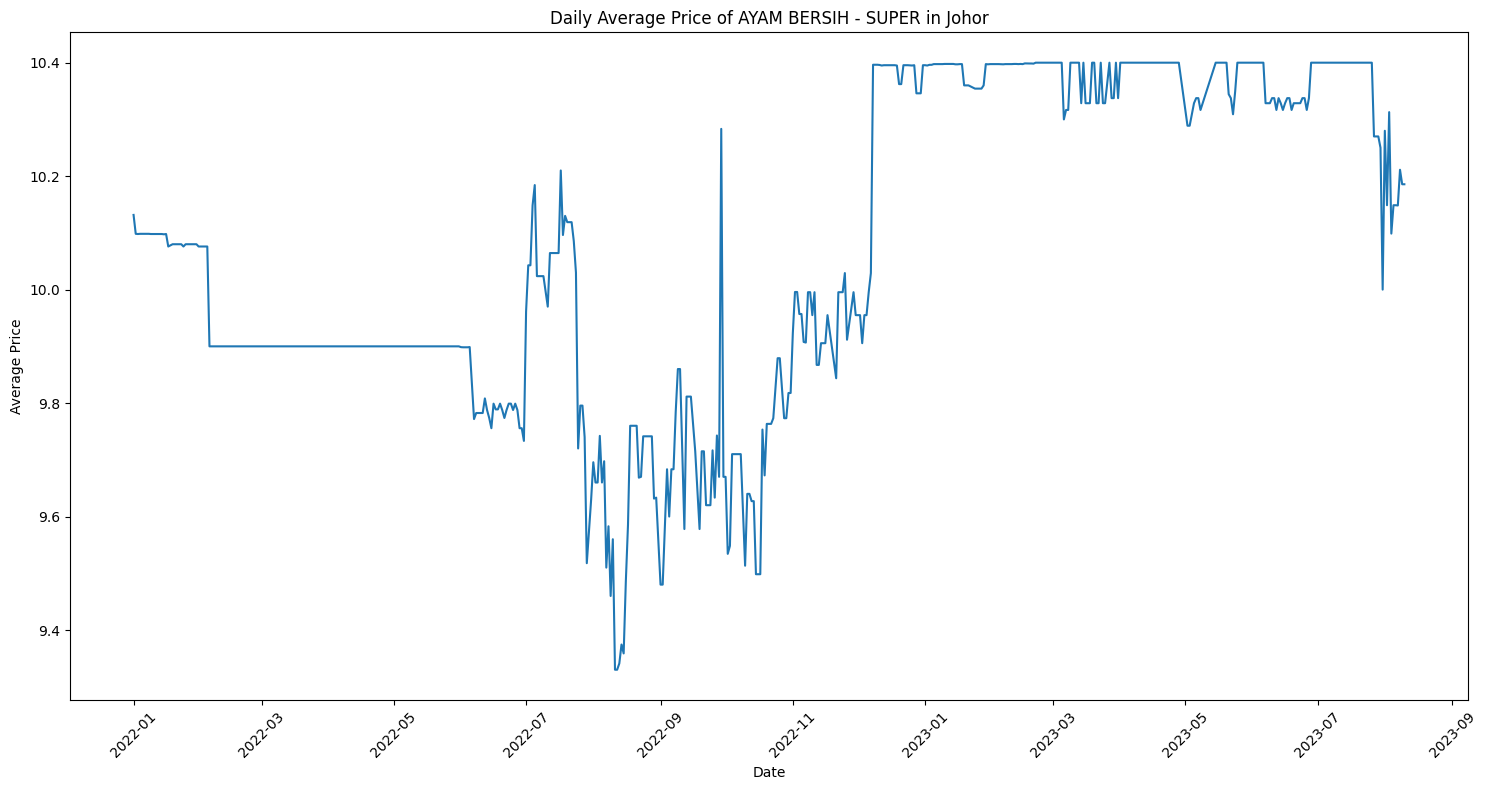

In [12]:
%matplotlib inline

daily_avg_price = filtered_data.groupby(filtered_data['date'].dt.date)['price'].mean()

plt.figure(figsize=(15, 8))
plt.plot(daily_avg_price.index, daily_avg_price.values)

if item_state is not None:
    item_state = filtered_data.iloc[0]['state']
    plt.title(f'Daily Average Price of {item_name} in {item_state}')
else:
    plt.title(f'Daily Average Price of {item_name} in Malaysia')

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()